<a href="https://colab.research.google.com/github/levimcclenny/notebooks/blob/main/Notebook1_ViscousBurgers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## *TensorDiffEq* Workshop Materials - Notebook 1
### Viscous Burgers Equation

In this notebook we will provide a brief overview of the interface of *TensorDiffEq* and how to implement its functionality to solve PDE systems. We will start with a basic implementation of a nonlinear PDE, the viscous Burger's Equation.

Specifically we will solve the PDE system:

$u_t + uu_x - (0.01/\pi) u_{xx} = 0, \ \ x \in [-1,1], t \in [0,1]$ \\
$u(0,x) = -sin(\pi x)$ \\
$u(t, -1) = u(t, 1) = 0 $

First, we must install the package, which can be done via *pip*

In [1]:
!pip install tensordiffeq

Now we run some manditory import statements, including math and scipy for importing the exact solution a little later on. Notice that we dont need to import Tensorflow as tdq installs that for us

In [2]:
import math
import scipy.io
import tensordiffeq as tdq
from tensordiffeq.boundaries import *
from tensordiffeq.models import CollocationSolverND

The first step of any forward or inverse problem is defining the domain on which the solution lies

In [3]:
Domain = DomainND(["x", "t"], time_var='t')

Domain.add("x", [-1.0, 1.0], 256)
Domain.add("t", [0.0, 1.0], 100)

Next, we need to generate collocation points inside the domain for training

In [4]:
N_f = 10000
Domain.generate_collocation_points(N_f)

Define the initial condition function

In [5]:
def func_ic(x):
    return -np.sin(x * math.pi)

Define the actual initial condition method, and the subsequent upper and lower dirichlect BCs. 

In [6]:
init = IC(Domain, [func_ic], var=[['x']])
upper_x = dirichletBC(Domain, val=0.0, var='x', target="upper")
lower_x = dirichletBC(Domain, val=0.0, var='x', target="lower")


tdq takes in initial conditions and boundary conditions as a list

In [7]:
BCs = [init, upper_x, lower_x]

Define the strong-form PDE in terms of tf.gradients where derivatives are required. 

In [8]:
def f_model(u_model, x, t):
    u = u_model(tf.concat([x, t], 1))
    u_x = tf.gradients(u, x)
    u_xx = tf.gradients(u_x, x)
    u_t = tf.gradients(u, t)
    f_u = u_t + u * u_x - (0.01 / tf.constant(math.pi)) * u_xx
    return f_u

Define layer sizes as a list of hidden layer widths

In [9]:
layer_sizes = [2, 20, 20, 20, 20, 20, 1]

Define the model, compile the model using the defined layer sizes, PDE model, and domain/BCs, and call model.fit

In [13]:
model = CollocationSolverND()
model.compile(layer_sizes, f_model, Domain, BCs)
# to reproduce results from Raissi and the SA-PINNs paper, train for 10k newton and 10k adam
model.fit(tf_iter=2000, newton_iter = 2000)

  ______                           ____  _ ______________     
 /_  __/__  ____  _________  _____/ __ \(_) __/ __/ ____/___ _
  / / / _ \/ __ \/ ___/ __ \/ ___/ / / / / /_/ /_/ __/ / __ `/
 / / /  __/ / / (__  ) /_/ / /  / /_/ / / __/ __/ /___/ /_/ / 
/_/  \___/_/ /_/____/\____/_/  /_____/_/_/ /_/ /_____/\__, /  
                                                        /_/   

Neural Network Model Summary

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 20)                60        
_________________________________________________________________
dense_7 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_8 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_9 (Dense)              (None, 20)  


Starting L-BFGS training
Executing eager-mode L-BFGS


Download high-fidelity solution data for comparison and L2 error calculations

In [14]:
!wget --no-check-certificate https://github.com/tensordiffeq/TensorDiffEq/blob/main/examples/burgers_shock.mat?raw=true \
    -O burgers_shock.mat

--2021-05-06 02:03:09--  https://github.com/tensordiffeq/TensorDiffEq/blob/main/examples/burgers_shock.mat?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tensordiffeq/TensorDiffEq/raw/main/examples/burgers_shock.mat [following]
--2021-05-06 02:03:10--  https://github.com/tensordiffeq/TensorDiffEq/raw/main/examples/burgers_shock.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tensordiffeq/TensorDiffEq/main/examples/burgers_shock.mat [following]
--2021-05-06 02:03:10--  https://raw.githubusercontent.com/tensordiffeq/TensorDiffEq/main/examples/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.github

Import the high-fidelity solution, calculate the L2 error, and plot the solution domain 

Error u: 4.793710e-03


No handles with labels found to put in legend.


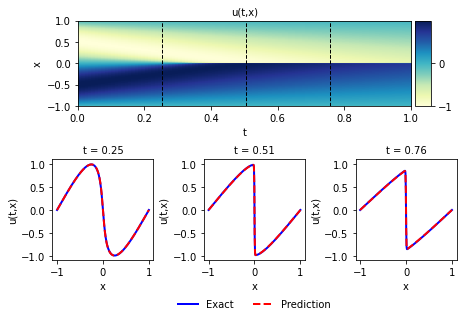

In [12]:
data = scipy.io.loadmat('burgers_shock.mat')

Exact = data['usol']
Exact_u = np.real(Exact)

# t = data['tt'].flatten()[:,None]
# x = data['x'].flatten()[:,None]

x = Domain.domaindict[0]['xlinspace']
t = Domain.domaindict[1]["tlinspace"]

X, T = np.meshgrid(x, t)

# print(np.shape((X,T))) #2, 100, 256
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact_u.T.flatten()[:, None]

u_pred, f_u_pred = model.predict(X_star)

error_u = tdq.helpers.find_L2_error(u_pred, u_star)
print('Error u: %e' % (error_u))

U_pred = tdq.plotting.get_griddata(X_star, u_pred.flatten(), (X, T))
FU_pred = tdq.plotting.get_griddata(X_star, f_u_pred.flatten(), (X, T))

lb = np.array([-1.0, 0.0])
ub = np.array([1.0, 1])

tdq.plotting.plot_solution_domain1D(model, [x, t], ub=ub, lb=lb, Exact_u=Exact_u)